### Load data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907.csv")

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Date', 'BTC_Close', 'BTC_High', 'BTC_Low', 'BTC_Open']]

#### Split train, test period

In [3]:
start_day_p2 = pd.Timestamp(2018, 10, 1)
test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period2 = data[(data["Date"] <= end_day_p2)].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)
train_dataset_p2 = train_dataset_p2.drop(columns = ["Date"])
test_dataset_p2 = test_dataset_p2.drop(columns = ["Date"])

### List Evaluation metrics

In [4]:
# Metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score

def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100

### Function to create X and y

In [5]:
# Function to create X and y
def create_train_test(train_dataset, test_dataset):
	X_train = train_dataset[:-1]
	Y_train = train_dataset["BTC_Close"][1:]
	X_test = test_dataset[:-1]
	Y_test = test_dataset["BTC_Close"][1:]
	return X_train, Y_train, X_test, Y_test

X_train_p2, Y_train_p2, X_test_p2, Y_test_p2 = create_train_test(train_dataset_p2, test_dataset_p2)

### Create model

#### Create ParamGrid

In [6]:
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
params = {
    'min_child_weight': [0.5, 1, 2],
    'gamma': [1, 2, 5],
    'subsample': [0.6, 0.8, 0.8, 1.0],
    'colsample_bytree': [1],
    'max_depth': [6, 8, 10, 12],
    'objective': ['reg:squarederror'],
    'learning_rate': [0.01]
}

param_grid = list(ParameterGrid(params))
print(len(param_grid))
print(param_grid[0])

xgb = XGBRegressor(n_estimators=500,
                   objective='reg:squarederror')

144
{'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 0.5, 'objective': 'reg:squarederror', 'subsample': 0.6}


In [7]:
import gc
final_model = None
best_score = 1000000000

for param in param_grid:
    xgb.set_params(**param)
    xgb.fit(X_train_p2, Y_train_p2)
    Y_pred = xgb.predict(X_test_p2)
    score = root_mean_squared_error(Y_test_p2, Y_pred)
    if score < best_score:
        best_score = score
        final_model = xgb
        best_param = param
    gc.collect()
    print(param, score)

{'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 0.5, 'objective': 'reg:squarederror', 'subsample': 0.6} 3780.6160719929394
{'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 0.5, 'objective': 'reg:squarederror', 'subsample': 0.8} 3839.196402905602
{'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 0.5, 'objective': 'reg:squarederror', 'subsample': 0.8} 3839.196402905602
{'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 0.5, 'objective': 'reg:squarederror', 'subsample': 1.0} 4195.65176769611
{'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'subsample': 0.6} 3780.6160719929394
{'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'subsample': 0.8} 3839.19

{'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 2, 'objective': 'reg:squarederror', 'subsample': 1.0} 3179.9947602006673
R2 score:  0.8418714707606949
directional_accuracy:  46.96132596685083


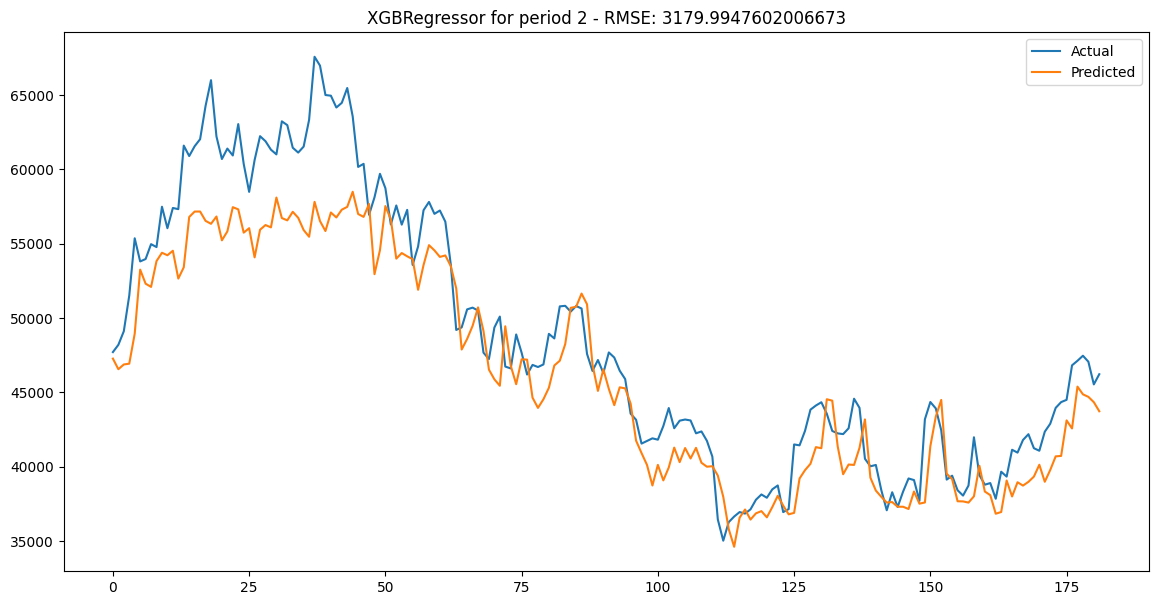

In [8]:
print(best_param, best_score)
# plot prediction
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.title(f"XGBRegressor for period 2 - RMSE: {best_score}")
Y_pred = final_model.predict(X_test_p2)
print("R2 score: ", r2_score(Y_test_p2, Y_pred))
print("directional_accuracy: ", directional_accuracy(Y_test_p2, Y_pred))
plt.plot(Y_test_p2.values, label="Actual")
plt.plot(Y_pred, label="Predicted")
plt.legend()
plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

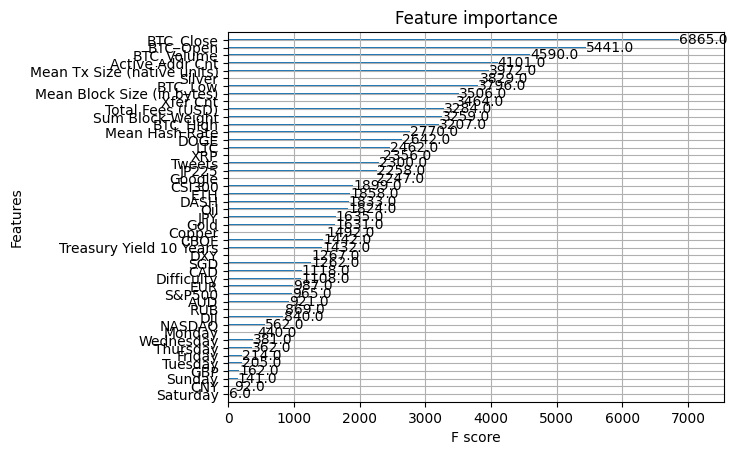

In [9]:
# plot feature importance
from xgboost import plot_importance
plot_importance(final_model)

In [10]:
import pickle
import os
file_name = "/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/implementations/models/xgboost_p2.pkl"
if not os.path.exists(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
pickle.dump(final_model, open(file_name, "wb"))

In [11]:
import pickle
name = 'period2'
model = 'xgb'
file = open(f"/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/tianen101/implementations/results/{name}/{model}.pkl", "wb")